In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.functional as F
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import lightning as L
from torch.utils.data import random_split, DataLoader
from torchinfo import summary
import matplotlib.pyplot as plt

# Convolutional Neural Networks

Convolutional Neural Networks (also known as CNNs or ConvNets) represent a family of models that have been tremendously successful in computer vision. Inspired by the study of the brain's visual cortex, they can be applied to images, videos and even sequential data. This notebook focuses on how convolutional neural networks are applied to computer vision problems and how the pieces they are made of . It contains multiple examples of using convolutional layers to create CNNs. 

Convolutional Neural Networks (also known as CNNs or ConvNets) represent a family of models that have been tremendously successful in computer vision. Inspired by the study of the brain's visual cortex, they can be applied to images, videos, and even sequential data. This notebook focuses on how convolutional neural networks are applied to computer vision problems, the layers they are made of, and how these layers work.

Let's get started!

## A simple first ConvNet: The FashionMNIST dataset

We'll start by training a simple ConvNet using the familiar FashionMNIS dataset of the last handout. As a reminder, this is a dataset of 60,000 28x28 grayscale images of 10 fashion categories, along with a test set of 10,000 images. The categories are:

| Label | Description |
| ----- | ----------- |
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |


Let's fetch the data using a lighting's data module:

In [2]:
class FashionDataModule(L.LightningDataModule):
    def __init__(self, data_path='./datasets'):
        super().__init__()
        self.data_path = data_path
        self.transform = transforms.Compose([transforms.ToTensor()])
        self.class_names = pd.Series(["T-shirt/top", "Trouser", "Pullover", "Dress", 
                                      "Coat", "Sandal", "Shirt", "Sneaker", "Bag", 
                                      "Ankle boot"])
        
    def prepare_data(self):
        datasets.FashionMNIST(root=self.data_path, train=True, download=True) 
        datasets.FashionMNIST(root=self.data_path, train=False, download=True) 

    def setup(self, stage=None): # stage is either 'fit', 'validate', 'test', or 'predict'
        self.ds_train, self.ds_val = random_split(
            datasets.FashionMNIST(self.data_path, train=True, download=False, 
                                  transform=transforms.ToTensor()), [.8, .2])
        self.ds_test = datasets.FashionMNIST(self.data_path, train=False, download=False, 
                                             transform=transforms.ToTensor())

    def train_dataloader(self):
        return DataLoader(self.ds_train, batch_size=64, num_workers=4, persistent_workers=True)

    def val_dataloader(self):
        return DataLoader(self.ds_val, batch_size=64, num_workers=4, persistent_workers=True)

    def test_dataloader(self):
        return DataLoader(self.ds_test, batch_size=64, num_workers=4, persistent_workers=True)
    
fashion_dm = FashionDataModule()

Let's take a look at a sample of the images in this data set. We'll use the `plt.imshow()` function to display these images using the binary color map.

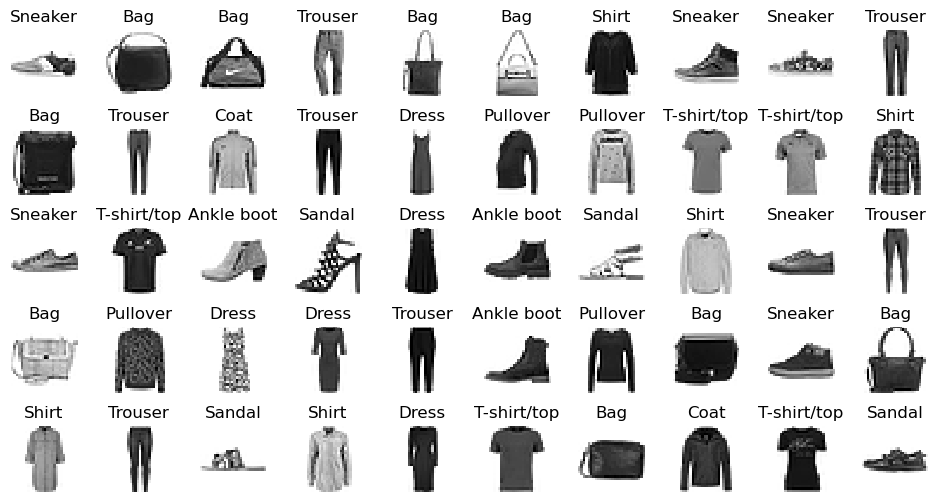

In [3]:
from PIL import Image

n_rows = 5
n_cols = 10

fashion_dm.prepare_data()
fashion_dm.setup()
ds_train = fashion_dm.train_dataloader().dataset
class_names = fashion_dm.class_names

plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(Image.fromarray(np.uint8(ds_train[index][0].squeeze() * 255)), cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[ds_train[index][1]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

We now shift our attention to the ConvNet. We'll use two convolutional layers (`Conv2d`), each with ReLU activation, followed by a max-pooling layer. This is a common pattern in ConvNets for image classification. The convolutional layers with ReLU activation are responsible for feature extraction, and the max-pooling layers reduce spatial dimensions while retaining important features. This kind of structure is effective for learning hierarchical representations from input images. After that, we flatten the result of the convolutional and pooling layers and pass the output to a linear layer.

Let's assemble the layers of the model manually first before we package it into a lightning module. Here are the convolutional and pooling layers.

In [4]:
model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
)

As you can see, the first convolutional layer has 1 input channel (for grayscale images), 32 output channels (or feature maps), and uses a 3 by 3 kernel. The second convolutional layer takes the 32 output channels of the first convolutional layer as its input channels and has 64 output channels and a 3 by 3 kernel.

The input grayscale images are in the NCWH format. A pooling layer with a kernel size of 2 and a stride of 2 will produce an output that has roughly half of its input width and height without affecting the number of channels or feature maps

For example, for batch of a single dummy input image like this:

In [5]:
img = torch.ones(1,1,28,28)

Here is the shape of the output of the first convolutional layer:

In [6]:
model[0](img).shape

torch.Size([1, 32, 28, 28])

which has, as expected, 32 channels. Let's see the shape of the first max pooling layer:

In [7]:
model[2](
    model[1](
        model[0](img)
    )
).shape

torch.Size([1, 32, 14, 14])

meaning that the width and the height of the input image is reduced by the pooling layer from 28 by 28 to 14 by 14. 

Let's add the flatten layer and call the model again:

In [8]:
model.add_module("flatten", nn.Flatten())
model(img).shape

torch.Size([1, 3136])

With that, we know what value to pass to the linear layer for its input features parameter: 3136.

In [9]:
model.add_module("out", nn.Linear(3136, 10))
model(img).shape

torch.Size([1, 10])

Notice the position of the `Flatten` layer. It's at the beginning in the fully-connected models we saw in the last handout and towards the end in this ConvNet. Having done that, we can package this model with all of its layers into a Lightning module.

**IMPORTANT:** This notebook will have many Lightning models that share the same training, validation, testing steps, and hooks. To avoid code duplication, let's isolate these shared functions into a base module like this.

In [10]:
from torchmetrics import Accuracy
class BaseModule(L.LightningModule):
    def __init__(self, lr=0.001):
        super().__init__()
        self.lr = lr
        
        self.train_accuracy = Accuracy(task="multiclass", num_classes=10)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=10)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=10)

    def _common_step(self, batch, batch_idx, accuracy, loss_lbl, accuracy_lbl):
        X, y = batch
        logits = self(X)
        loss = nn.functional.cross_entropy(logits, y)
        y_hat = torch.argmax(logits, dim=1)
        self.log(loss_lbl, loss, prog_bar=True)
        self.log(accuracy_lbl, accuracy(y_hat, y), prog_bar=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, self.train_accuracy, "loss", "accuracy")

    def on_training_epoch_end(self):
        self.log("accuracy", self.train_accuracy.compute())
        self.train_accuracy.reset()
    
    def validation_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, self.val_accuracy, "val_loss", "val_accuracy")

    def on_validation_epoch_end(self):
        self.log("val_accuracy", self.val_accuracy.compute())
        self.val_accuracy.reset()

    def test_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, self.test_accuracy, "test_loss", "test_accuracy")

    def on_test_epoch_end(self):
        self.log("test_accuracy", self.test_accuracy.compute())
        self.test_accuracy.reset()
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

Having done that, here is the model. As you can see, subclassing from the `BaseModule` class we just created, which in turn subclasses `LightningModule`, makes all these shared methods available to our model without a lot of code repetition

In [11]:
class FashionModel(BaseModule):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(3136, 10)
        )

    def forward(self, x):
        return self.cnn(x)

model = FashionModel()

Let's summarize this ConvNet:

In [12]:
summary(model)

Layer (type:depth-idx)                   Param #
FashionModel                             --
├─MulticlassAccuracy: 1-1                --
├─MulticlassAccuracy: 1-2                --
├─MulticlassAccuracy: 1-3                --
├─Sequential: 1-4                        --
│    └─Conv2d: 2-1                       320
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
│    └─Conv2d: 2-4                       18,496
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
│    └─Flatten: 2-7                      --
│    └─Linear: 2-8                       31,370
Total params: 50,186
Trainable params: 50,186
Non-trainable params: 0

And let's plot it:

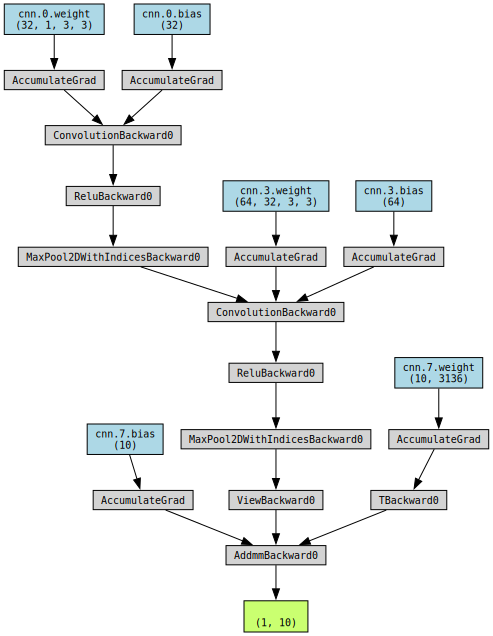

In [13]:
from torchviz import make_dot
make_dot(model(ds_train[0][0].unsqueeze(dim=0)), params=dict(model.named_parameters()))

Now we can train it:

In [14]:
trainer = L.Trainer(max_epochs=10)
trainer.fit(model=model, datamodule=fashion_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type               | Params
------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0     
1 | val_accuracy   | MulticlassAccuracy | 0     
2 | test_accuracy  | MulticlassAccuracy | 0     
3 | cnn            | Sequential         | 50.2 K
------------------------------------------------------
50.2 K    Trainable params
0         Non-trainable params
50.2 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Finally, we evaluate it:

In [15]:
trainer.test(model, dataloaders=fashion_dm)

Testing: |                                                | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9036999940872192     │
│         test_loss         │    0.2887954115867615     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.2887954115867615, 'test_accuracy': 0.9036999940872192}]

With still a lot of room for improvement, this is a much better model than the previous feed-forward fully-connected model we did in the last handout. As you can see, the ConvNet model outperformed the fully-connected model (~88% vs. ~90% testing accuracy; you might get different numbers) with only a fraction of the parameters: 34,826 vs. 235,146 parameters.

## Another example:  The CIFAR10 benchmark dataset

This example uses CIFAR10, a data set of 50,000 32x32 color (RGB) training images and 10,000 test images with 10 categories. See more info at the [CIFAR homepage](https://www.cs.toronto.edu/~kriz/cifar.html). The categories of this dataset are:
| Label | Description |
| ----- | ----------- |
| 0     | airplane    |
| 1     | automobile  |
| 2     | bird        |
| 3     | cat         |
| 4     | deer        |
| 5     | dog         |
| 6     | frog        |
| 7     | horse       |
| 8     | ship        |
| 9     | truck       |

Let's download the dataset, split it into three sets and create the required data loaders.

In [16]:
class CIFAR10DataModule(L.LightningDataModule):
    def __init__(self, data_path='./datasets'):
        super().__init__()
        self.data_path = data_path
        self.transform = transforms.Compose([transforms.ToTensor()])
        self.class_names = pd.Series(['airplane', 'automobile', 'bird', 'cat', 'deer', 
                                      'dog', 'frog', 'horse', 'ship', 'truck'])

    def prepare_data(self):
        datasets.CIFAR10(root=self.data_path, train=True, download=True)
        datasets.CIFAR10(root=self.data_path, train=False, download=True) 

    def setup(self, stage=None):
        ds_main = datasets.CIFAR10(self.data_path, train=True, download=False, transform=transforms.ToTensor())
        self.ds_val = torch.utils.data.Subset(ds_main, torch.arange(10000))
        self.ds_train = torch.utils.data.Subset(ds_main, torch.arange(10000, len(ds_main)))
        
        self.ds_test = datasets.CIFAR10(self.data_path, train=False, download=False, transform=transforms.ToTensor())

    def train_dataloader(self):
        return DataLoader(self.ds_train, batch_size=64, num_workers=4, persistent_workers=True)

    def val_dataloader(self):
        return DataLoader(self.ds_val, batch_size=64, num_workers=4, persistent_workers=True)

    def test_dataloader(self):
        return DataLoader(self.ds_test, batch_size=64, num_workers=4, persistent_workers=True)
    
cifar10_dm = CIFAR10DataModule()

Let's see a few of these images:

Files already downloaded and verified
Files already downloaded and verified


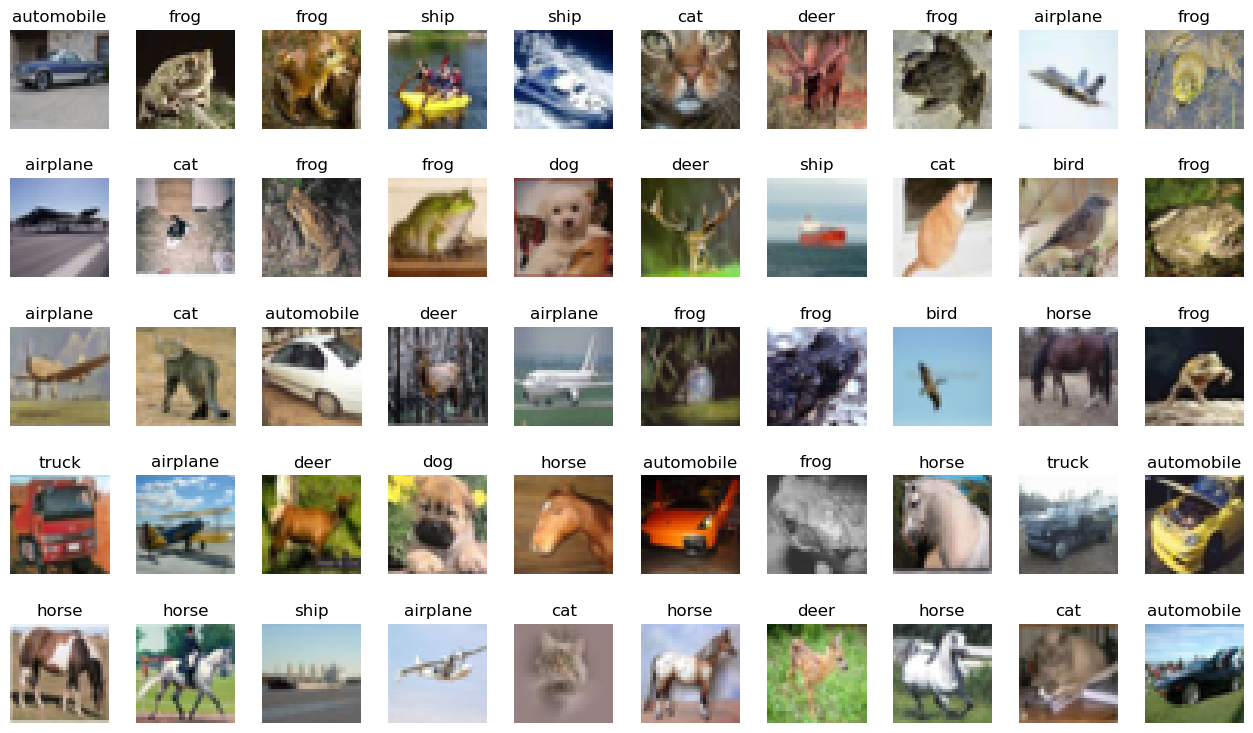

In [17]:
n_rows = 5
n_cols = 10
cifar10_dm.prepare_data()
cifar10_dm.setup()
ds_train = cifar10_dm.train_dataloader().dataset
class_names = cifar10_dm.class_names

plt.figure(figsize=(16, 9))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(Image.fromarray(np.uint8(ds_train[index][0].permute(1, 2, 0) * 255)))
        plt.axis('off')
        plt.title(class_names[ds_train[index][1]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Color images have three channels: a red channel, a green channel, and a blue channel. Each image in this dataset is 32 by 32.

In [18]:
ds_train[0][0].shape

torch.Size([3, 32, 32])

We are now ready for model building and training. 

### Using a fully-connected model
To see how powerful ConvNets are, let's start a baseline feed-forward fully-connected model. This is a Lightning module subclassing from `BaseModule`.

In [19]:
class FCCifar10Model(BaseModule):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3 * 32 * 32, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)            
        )

    def forward(self, x):
        return self.fc(x)

fc_model = FCCifar10Model()

In [20]:
summary(fc_model)

Layer (type:depth-idx)                   Param #
FCCifar10Model                           --
├─MulticlassAccuracy: 1-1                --
├─MulticlassAccuracy: 1-2                --
├─MulticlassAccuracy: 1-3                --
├─Sequential: 1-4                        --
│    └─Flatten: 2-1                      --
│    └─Linear: 2-2                       786,688
│    └─BatchNorm1d: 2-3                  512
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       32,896
│    └─ReLU: 2-6                         --
│    └─BatchNorm1d: 2-7                  256
│    └─Linear: 2-8                       8,256
│    └─ReLU: 2-9                         --
│    └─Linear: 2-10                      650
Total params: 829,258
Trainable params: 829,258
Non-trainable params: 0

Let's train the model:

In [21]:
trainer = L.Trainer(max_epochs=10)
trainer.fit(model=fc_model, datamodule=cifar10_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified



  | Name           | Type               | Params
------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0     
1 | val_accuracy   | MulticlassAccuracy | 0     
2 | test_accuracy  | MulticlassAccuracy | 0     
3 | fc             | Sequential         | 829 K 
------------------------------------------------------
829 K     Trainable params
0         Non-trainable params
829 K     Total params
3.317     Total estimated model params size (MB)


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


And let's evaluate it using the testing set.

In [22]:
trainer.test(fc_model, dataloaders=cifar10_dm)

Files already downloaded and verified
Files already downloaded and verified


Testing: |                                                | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.43320000171661377    │
│         test_loss         │     2.054011106491089     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 2.054011106491089, 'test_accuracy': 0.43320000171661377}]

As you can see, this model did not do well: about 43% accuracy.

### Using a ConvNet
Let's see how a ConvNet with three convolutional layers does:

In [23]:
class CNNCifar10Model(BaseModule):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(64 * 4 * 4, 128),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.cnn(x)

cnn_model = CNNCifar10Model()

Let's summarize it:

In [24]:
summary(model)

Layer (type:depth-idx)                   Param #
FashionModel                             --
├─MulticlassAccuracy: 1-1                --
├─MulticlassAccuracy: 1-2                --
├─MulticlassAccuracy: 1-3                --
├─Sequential: 1-4                        --
│    └─Conv2d: 2-1                       320
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
│    └─Conv2d: 2-4                       18,496
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
│    └─Flatten: 2-7                      --
│    └─Linear: 2-8                       31,370
Total params: 50,186
Trainable params: 50,186
Non-trainable params: 0

and plot it:

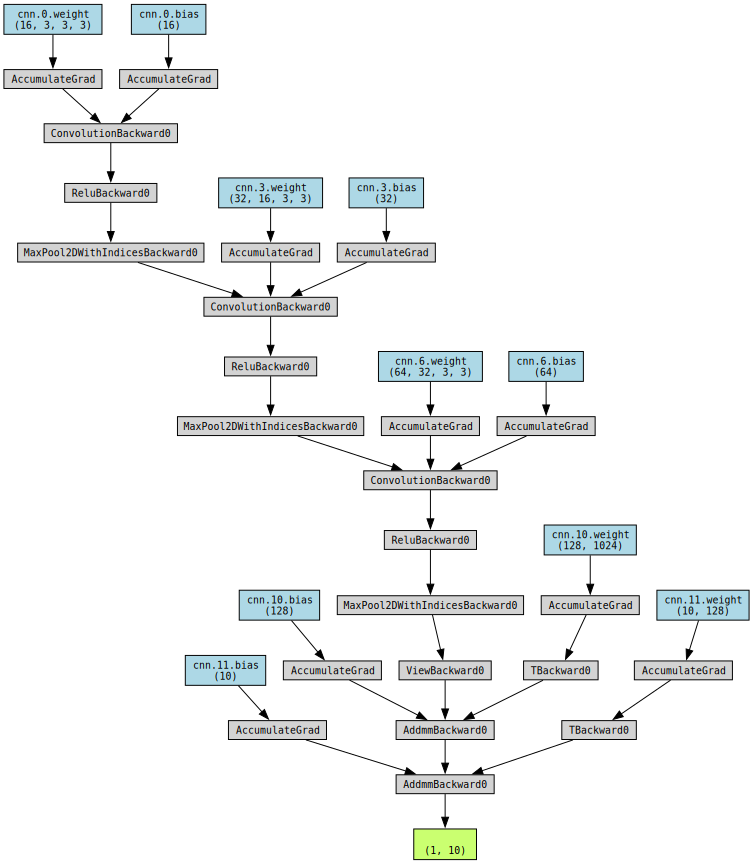

In [25]:
make_dot(cnn_model(ds_train[0][0].unsqueeze(dim=0)), params=dict(cnn_model.named_parameters()))

Let's train this ConvNet:

In [26]:
trainer = L.Trainer(max_epochs=10)
trainer.fit(model=cnn_model, datamodule=cifar10_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified



  | Name           | Type               | Params
------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0     
1 | val_accuracy   | MulticlassAccuracy | 0     
2 | test_accuracy  | MulticlassAccuracy | 0     
3 | cnn            | Sequential         | 156 K 
------------------------------------------------------
156 K     Trainable params
0         Non-trainable params
156 K     Total params
0.624     Total estimated model params size (MB)


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Let's, finally, evaluate it:

In [27]:
trainer.test(cnn_model, dataloaders=cifar10_dm)

Files already downloaded and verified
Files already downloaded and verified


Testing: |                                                | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.6672999858856201     │
│         test_loss         │    0.9992462992668152     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.9992462992668152, 'test_accuracy': 0.6672999858856201}]

This represents a substantial improvement over the fully-connected model while utilizing only a fraction of the parameters. Nevertheless, there is still progress to be made with this dataset.

### Using batch normalization and dropout

As a final model, let's try a more powerful and deeper ConvNet on this CIFAR10, that improves upon the previous model by using 2D batch normalization and dropout layers. We'll call it `CNNPlusCifar10Model`.

In [28]:
class CNNPlusCifar10Model(BaseModule):
    def __init__(self):
        super().__init__()
        
        model = nn.Sequential()
        start_filters = 3
        for i, (filters, rate) in enumerate([(32, .2), (64, .3), (128, .4)]):
            model.add_module(f"conv1-{i}", nn.Conv2d(start_filters, filters, kernel_size=3, padding=1))
            model.add_module(f"bnrm1-{i}", nn.BatchNorm2d(filters))
            model.add_module(f"relu1-{i}", nn.ReLU())
            model.add_module(f"conv2-{i}", nn.Conv2d(filters, filters, kernel_size=3, padding=1))
            model.add_module(f"bnrm2-{i}", nn.BatchNorm2d(filters))
            model.add_module(f"relu2-{i}", nn.ReLU())
            model.add_module(f"maxpl-{i}", nn.MaxPool2d(kernel_size=2, stride=2))
            model.add_module(f"drpot-{i}", nn.Dropout2d(rate))
            start_filters = filters

        model.add_module("flatten", nn.Flatten())
        model.add_module("out", nn.Linear(128 * 4 * 4, 10))
        
        self.cnn = model
    def forward(self, x):
        return self.cnn(x)

cnnplus_model = CNNPlusCifar10Model()

Here is a summary of this ConvNet:

In [29]:
summary(cnnplus_model)

Layer (type:depth-idx)                   Param #
CNNPlusCifar10Model                      --
├─MulticlassAccuracy: 1-1                --
├─MulticlassAccuracy: 1-2                --
├─MulticlassAccuracy: 1-3                --
├─Sequential: 1-4                        --
│    └─Conv2d: 2-1                       896
│    └─BatchNorm2d: 2-2                  64
│    └─ReLU: 2-3                         --
│    └─Conv2d: 2-4                       9,248
│    └─BatchNorm2d: 2-5                  64
│    └─ReLU: 2-6                         --
│    └─MaxPool2d: 2-7                    --
│    └─Dropout2d: 2-8                    --
│    └─Conv2d: 2-9                       18,496
│    └─BatchNorm2d: 2-10                 128
│    └─ReLU: 2-11                        --
│    └─Conv2d: 2-12                      36,928
│    └─BatchNorm2d: 2-13                 128
│    └─ReLU: 2-14                        --
│    └─MaxPool2d: 2-15                   --
│    └─Dropout2d: 2-16                   --
│    └─Conv2d

And here is a plot of it.

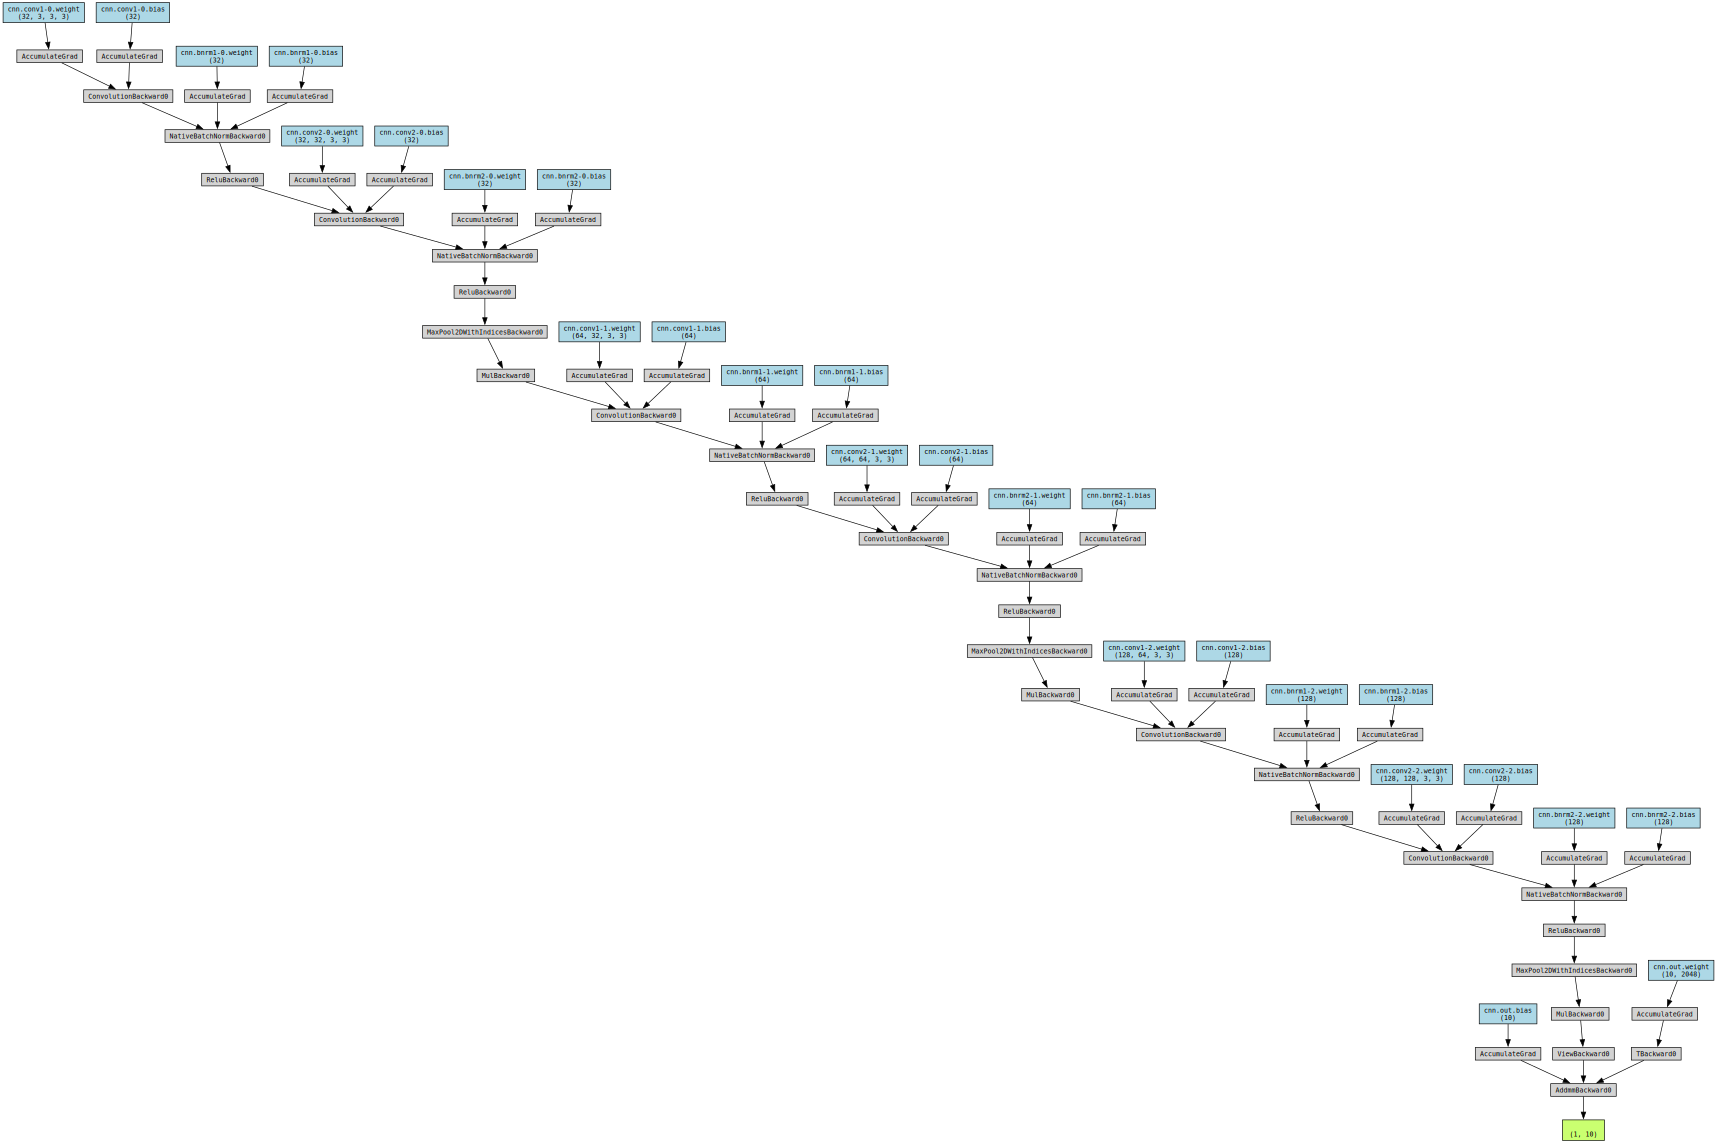

In [30]:
make_dot(cnnplus_model(ds_train[0][0].unsqueeze(dim=0)), params=dict(cnnplus_model.named_parameters()))

Let's train this new ConvNet:

In [31]:
trainer = L.Trainer(max_epochs=10)
trainer.fit(model=cnnplus_model, datamodule=cifar10_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified



  | Name           | Type               | Params
------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0     
1 | val_accuracy   | MulticlassAccuracy | 0     
2 | test_accuracy  | MulticlassAccuracy | 0     
3 | cnn            | Sequential         | 308 K 
------------------------------------------------------
308 K     Trainable params
0         Non-trainable params
308 K     Total params
1.234     Total estimated model params size (MB)


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


And finally, let's evaluate it:

In [32]:
trainer.test(cnnplus_model, dataloaders=cifar10_dm)

Files already downloaded and verified
Files already downloaded and verified


Testing: |                                                | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7882999777793884     │
│         test_loss         │    0.6178777813911438     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6178777813911438, 'test_accuracy': 0.7882999777793884}]

That represents a sizable improvement over the last ConvNet. However, there is still a lot more that can be done with this dataset. Feel free to continue experimenting with it.

## Understanding ConvNets: Looking under the hood
Having seen what ConvNets look like, let's explore how convolutions work, what kernels (filters) do, and what output channels (feature maps) look like.

### Peeking at feature maps

We start by looking under the hood of the above Convnet. Here are its layers

In [33]:
cnnplus_model

CNNPlusCifar10Model(
  (train_accuracy): MulticlassAccuracy()
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
  (cnn): Sequential(
    (conv1-0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bnrm1-0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1-0): ReLU()
    (conv2-0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bnrm2-0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2-0): ReLU()
    (maxpl-0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (drpot-0): Dropout2d(p=0.2, inplace=False)
    (conv1-1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bnrm1-1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1-1): ReLU()
    (conv2-1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bnrm2-1): BatchNorm2d(

As we know, each layer in this ConvNet is a callable object. By calling a layer and passing it some input, we are asking the layer to transform that input to some output. A convolutional layer outputs one or more channels (feature maps). Let's extract the first convolutional layer of this model (at index 0), pass it an image, and display the produced 32 feature maps.

Here is the image we'll be using for this demonstration:

torch.Size([3, 32, 32])


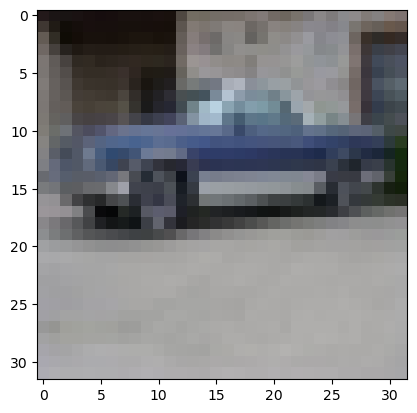

In [34]:
plt.imshow(Image.fromarray(np.uint8(ds_train[0][0].permute(1, 2, 0) * 255)))
print(ds_train[0][0].shape)

And here is the first convolutional layer:

In [35]:
conv2d_1 = cnnplus_model.cnn[0]

Let's call this layer on the image above and plot its produced feature maps:

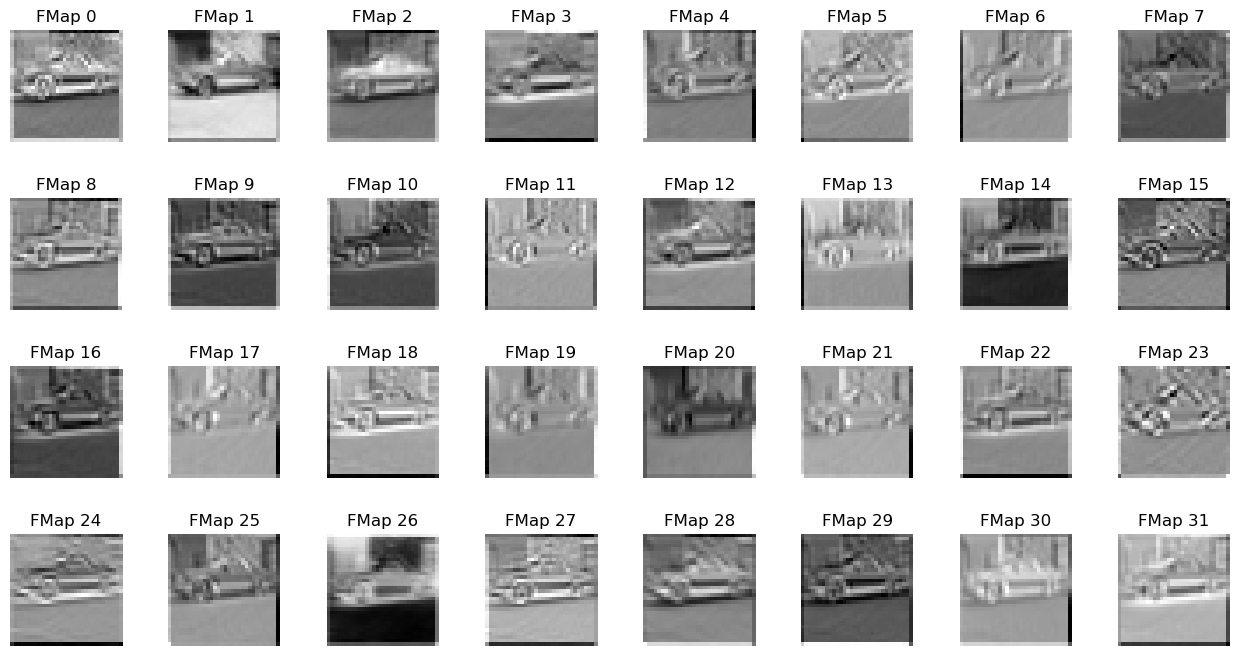

In [36]:
fmaps = conv2d_1(ds_train[0][0]).detach()

plt.figure(figsize=(16, 8))
for fm in range(32):
    plt.subplot(4, 8, fm + 1)
    plt.imshow(fmaps.permute(1, 2, 0)[:, :, fm], cmap="gray")
    plt.title(f"FMap {fm}")
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

As you can see, each feature map focuses on and highlights specific features of the image. To delve deeper into filters and their impact on feature maps, we require a different, larger image. Let's download one.

(3931, 2634, 3)

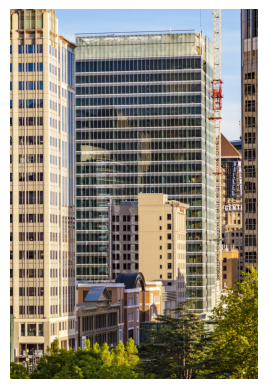

In [37]:
import urllib
from PIL import Image
im = Image.open(urllib.request.urlopen("https://upload.wikimedia.org/wikipedia/commons/0/0d/111_south_main_slc.jpg"))

img = np.array(im)
plt.imshow(img)
plt.axis("off")

img.shape

This is a large image. We'll crop it, take only the top third of it, and then resize it.

(300, 600, 3)

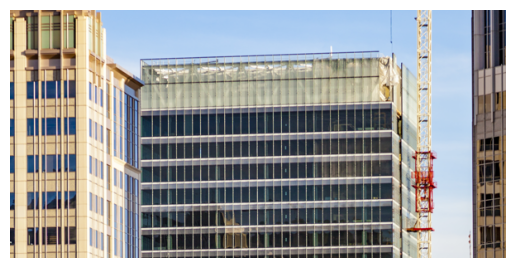

In [38]:
w, h = im.size

img = np.array(im.crop((0, 0, w, h / 3)).resize((600, 300)))

plt.imshow(img)
plt.axis("off")

img.shape

Now, we can pass this cropped image to a convolutional layer. To do this, we need to convert it from a 3-dimensional to a 4-dimensional shape. This is equivalent to placing it in a batch by itself. Additionally, we need to normalize its pixels by dividing them by 255.

In [39]:
new_img = torch.unsqueeze(torch.tensor(img), dim=0).permute(0, 3, 1, 2) / 255
new_img.shape, new_img.dtype

(torch.Size([1, 3, 300, 600]), torch.float32)

Now, let's create a convolutional layer with 16 kernels (the same number as the feature maps), each of which is 7 by 7 with a depth equal to the number of input channels (3 in this case). We'll accept the default initialization of its weights.

In [40]:
conv_layer = nn.Conv2d(3, 16, kernel_size=7, padding=1)
fmaps = conv_layer(new_img).detach()#.permute(0, 2, 3, 1).detach()
fmaps.shape

torch.Size([1, 16, 296, 596])

Here are the weights and biases of this convolutional layer. The weights are the kernels ( or filters).

In [41]:
kernels, biases = conv_layer.weight, conv_layer.bias

kernels.shape, biases.shape

(torch.Size([16, 3, 7, 7]), torch.Size([16]))

The above code also created 16 feature maps. Let's plot all of them:

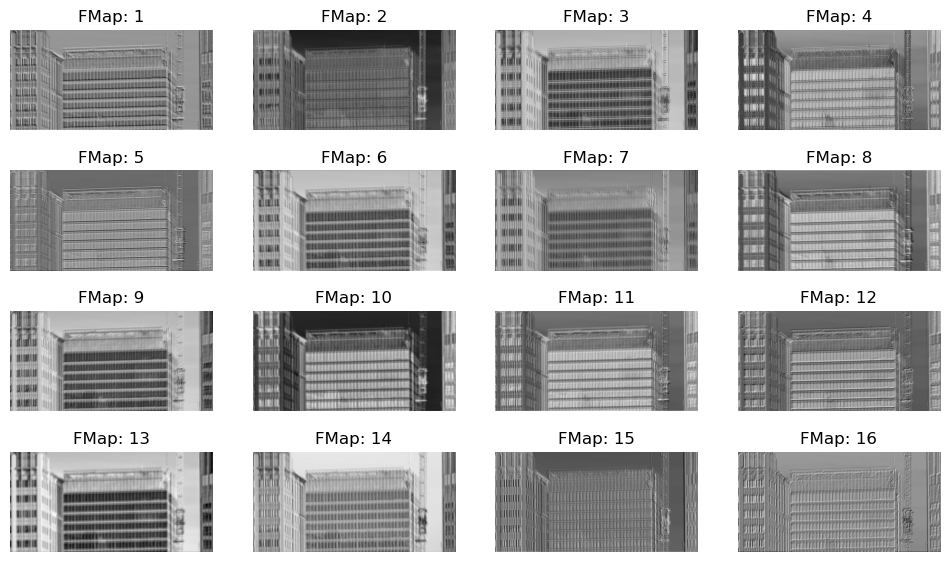

In [42]:
plt.figure(figsize=(12, 7))
for fm in range(16):
    plt.subplot(4, 4, fm + 1)
    plt.imshow(fmaps.permute(0, 2, 3, 1)[0, :, :, fm], cmap="gray")
    plt.title(f"FMap: {fm + 1}")
    plt.axis('off')

plt.show()

Although this layer has just been created and has not been trained, you can see that different feature maps capture certain things: edges, lines, small changes.

### Using hand-crafted filters

We can even pass our own custom filters to a convolutional layer and inspect its output feature maps. For example, let's create four filters:
- One with a horizontal line,
- Another with a vertical line,
- A third with a plus,
- A fourth with a square with a hole.

We will apply these filters to the color image above. Therefore, each filter will need to have three channels. For four 6 by 6 filters with three channels each, the filters tensor should have the shape `(4, 6, 6, 3)`.

In [54]:
filters = torch.zeros([4, 6, 6, 3])

# Filter 1
filters[0, 2:4, :, :] = 1

# Filter 2
filters[1, :, 2:4, :] = 1

# Filter 3
filters[2, 2:4, :, :] = 1
filters[2, :, 2:4, :] = 1

# Filter 4
filters[3, 2:4, 2:4, :] = 1

filters.shape

torch.Size([4, 6, 6, 3])

Let's plot these filters to see how they look:

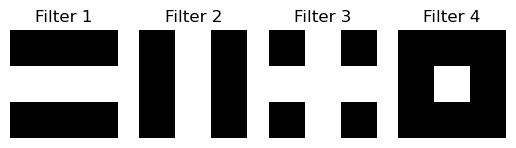

In [55]:
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(filters[i, :, :, :])
    plt.title(f"Filter { i + 1}")
    plt.axis('off')

To use these filters, we have to initialize the `Conv2d` layer's weights with these filters. We'll need to change the shape of the filters tensor above from:

In [56]:
filters.shape

torch.Size([4, 6, 6, 3])

to NCWH format like

In [57]:
filters.permute(0, 3, 1, 2).shape

torch.Size([4, 3, 6, 6])

Let's do that:

In [58]:
conv_layer = nn.Conv2d(3, 4, kernel_size=6, padding=1, stride=3)
conv_layer.weight.data.copy_(filters.permute(0, 3, 1, 2));

Let's apply this layer to the image above. This, again, will create 4 feature maps: one per filter.

In [59]:
fmaps = conv_layer(new_img).detach()
fmaps.shape

torch.Size([1, 4, 99, 199])

We can, now, plot the feature maps created by these hand-crafted filters.

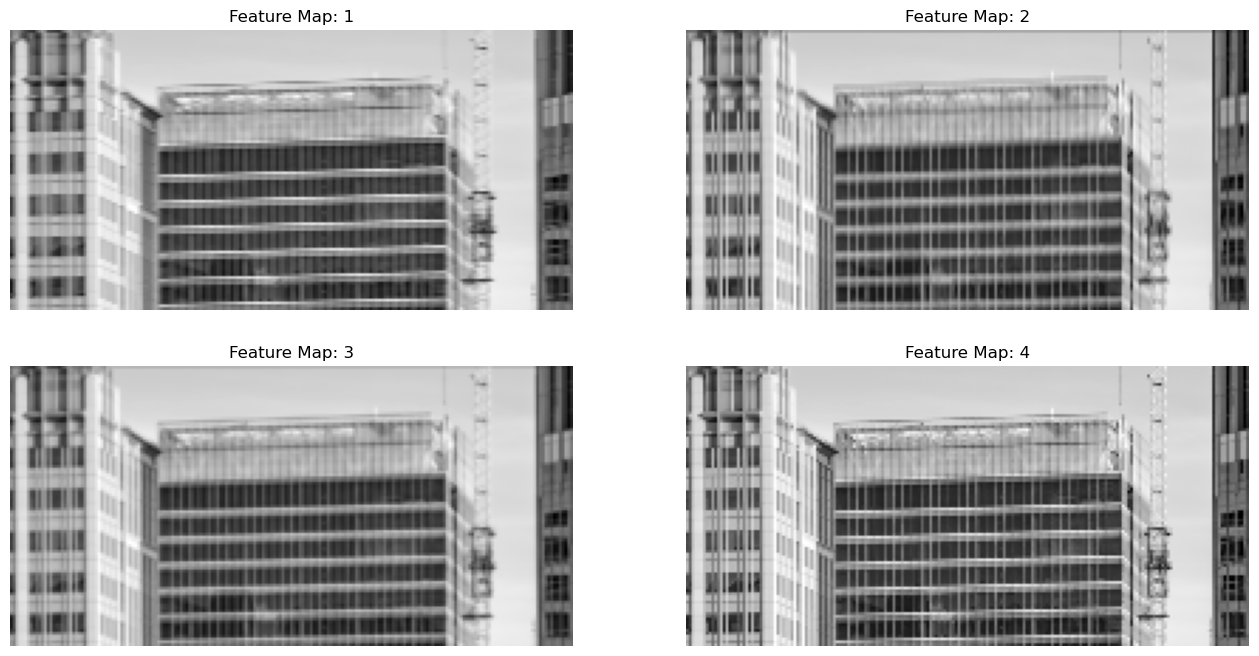

In [60]:
plt.figure(figsize=(16, 8))
for fm in range(4):
    plt.subplot(2, 2, fm + 1)
    plt.imshow(fmaps.permute(0, 2, 3, 1)[0, :, :, fm], cmap="gray")
    plt.title(f"Feature Map: {fm + 1}")
    plt.axis('off')

Notice how each feature map, produced by a different filter, is distinct. For instance, the first filter (the one with the horizontal line) highlights the horizontal lines in the image, while the second filter emphasizes vertical lines.

### The effect of pooling
Pooling layers are often used in conjunction with convolutional layers. A pooling layer takes the feature maps produced by a convolutional layer and downsamples them. Let's apply a max pooling layer to the above feature maps. This process will reduce the width and height of these feature maps by half. Importantly, pooling does not alter the number of feature maps.

We begin by printing the shape of the feature maps before pooling:

In [61]:
fmaps.shape

torch.Size([1, 4, 99, 199])

We, then, apply a max pooling layer and print the shape of its output.

In [62]:
pooled_fmaps = nn.MaxPool2d(kernel_size=2, stride=2)(fmaps)
pooled_fmaps.shape

torch.Size([1, 4, 49, 99])

Let's plot these pooled feature maps:

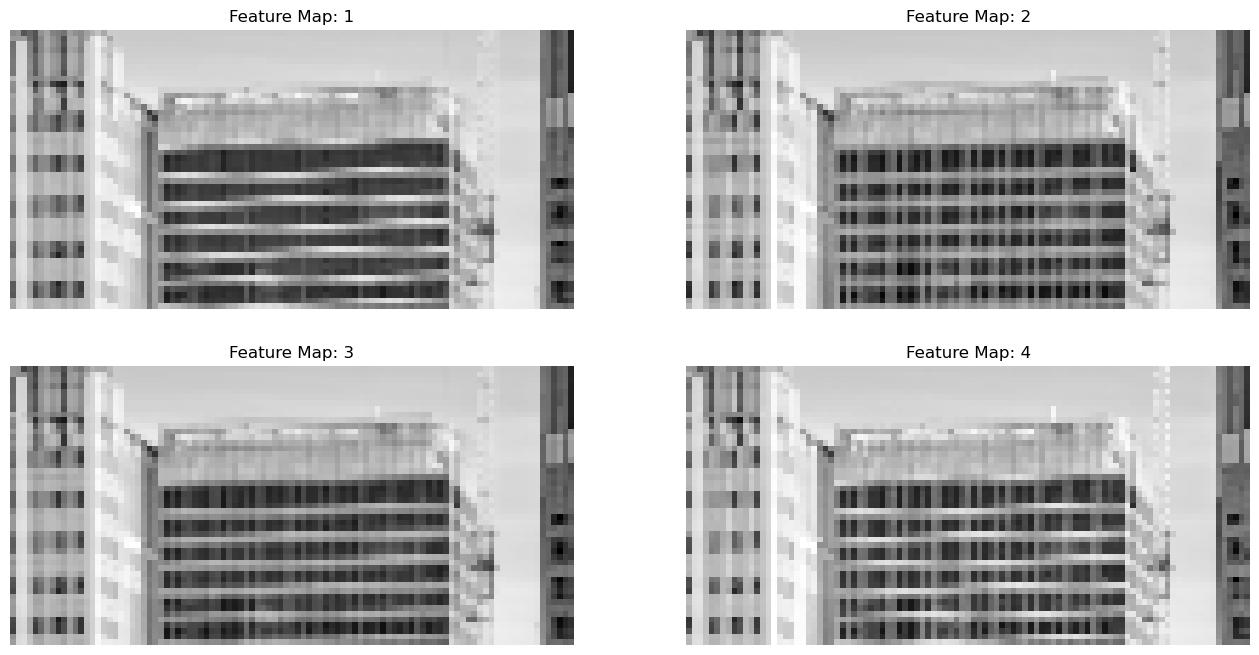

In [63]:
plt.figure(figsize=(16, 8))
for fm in range(4):
    plt.subplot(2, 2, fm + 1)
    plt.imshow(pooled_fmaps.permute(0, 2, 3, 1)[0, :, :, fm], cmap="gray")
    plt.title(f"Feature Map: {fm + 1}")
    plt.axis('off')

As you can see, the downsampling causes the feature map images to blur.

Finally, let's explore another form of pooling: average pooling. While this type of pooling has recently fallen out of favor, we'll examine it nonetheless.

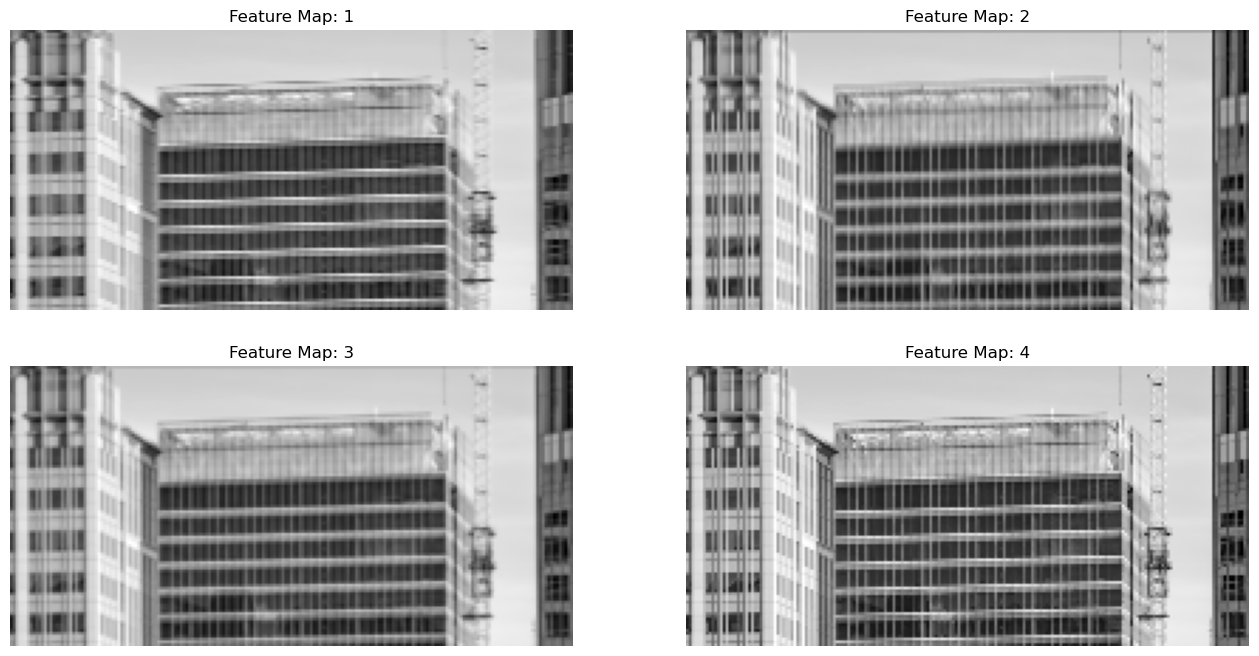

In [64]:
pooled_fmaps = nn.AvgPool2d(kernel_size=2, stride=2)(fmaps)

plt.figure(figsize=(16, 8))
for fm in range(4):
    plt.subplot(2, 2, fm + 1)
    plt.imshow(fmaps.permute(0, 2, 3, 1)[0, :, :, fm], cmap="gray")
    plt.title(f"Feature Map: {fm + 1}")
    plt.axis('off')